# **Final Project Notebook**
## *Electricity Production and Consumption Dataset*

In [2]:
#Imports

# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller


# Train/Test Splitting
from sklearn.model_selection import train_test_split

# Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense,TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Visulaizations
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [6]:
!pip install keras-tcn

#### 1) Reading the Dataset

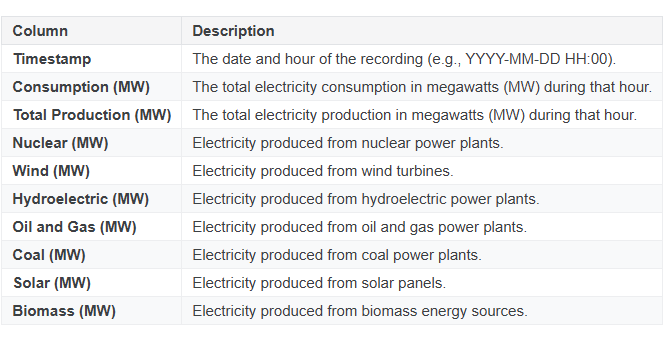

In [3]:
df=pd.read_csv('electricityConsumptionAndProductioction.csv',parse_dates = ['DateTime'],index_col='DateTime')
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


#### 2) Explore the Dataset

- Explore the Electricity trends over time

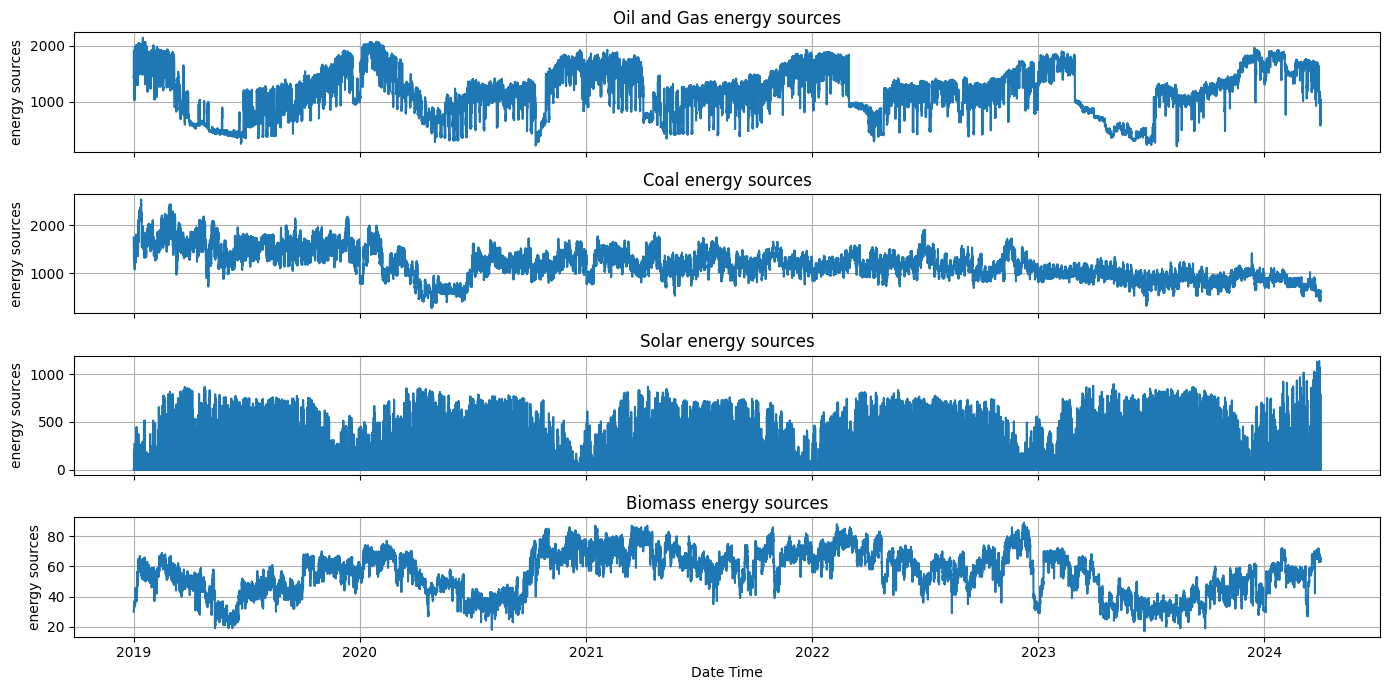

In [13]:
# Define the energy sources of interest
energy_sources = ['Oil and Gas', 'Coal', 'Solar', 'Biomass']

# Create subplots for the selected energy sources
fig, axes = plt.subplots(nrows=len(energy_sources), ncols=1, figsize=(14, 7), sharex=True)

# Plot each energy source in its own subplot
for i, source in enumerate(energy_sources):
    axes[i].plot(df.index, df[source], label=source)
    axes[i].set_ylabel('energy sources')
    axes[i].set_title(f'{source} energy sources')
    axes[i].grid(True)

# Set common x-axis label and adjust layout
plt.xlabel('Date Time')
plt.tight_layout()
plt.show()

- The Distribution of Electricity Generation by Source

 *Comparing the distributions of electricity generation from different sources (nuclear, wind, hydroelectric) using histograms*




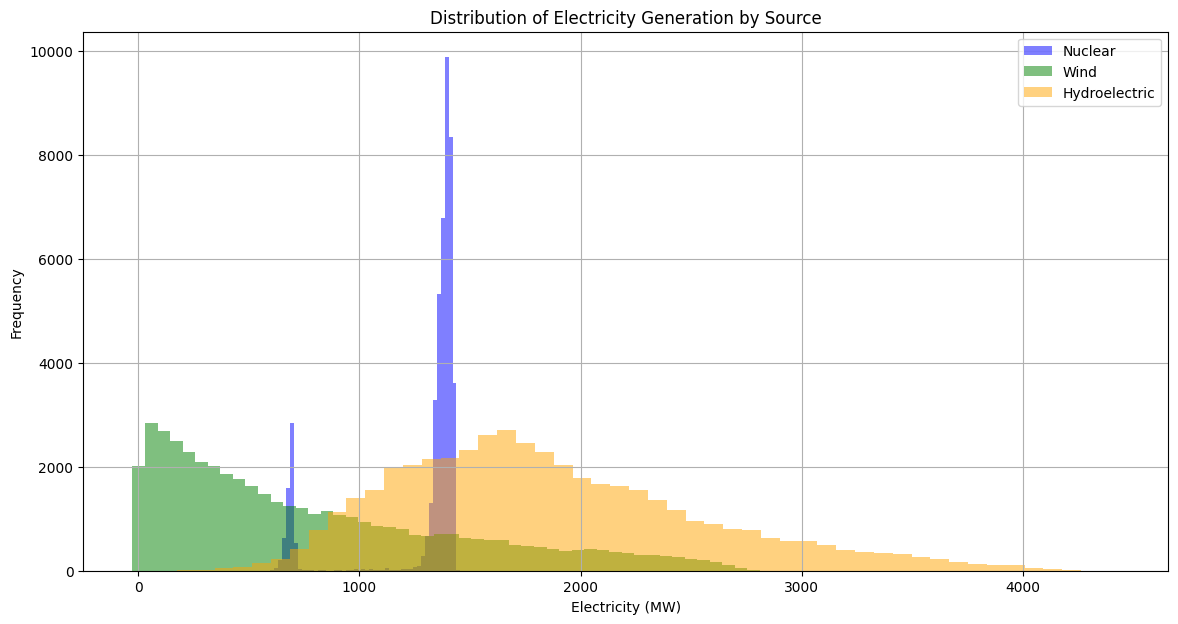

In [14]:
plt.figure(figsize=(14, 7))

plt.hist(df['Nuclear'], bins=50, alpha=0.5, label='Nuclear', color='blue')
plt.hist(df['Wind'], bins=50, alpha=0.5, label='Wind', color='green')
plt.hist(df['Hydroelectric'], bins=50, alpha=0.5, label='Hydroelectric', color='orange')

plt.xlabel('Electricity (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Generation by Source')
plt.legend()
plt.grid(True)
plt.show()


1.   The Histogram shows that the Frequency of production of Nuclear,wind and Hydroelectric.

2.  By this plot it is shown that Nuclear production is Higher than wind and Hydroelectric.

- Lineplot of Hourly Electricity Consumption and Production.

*Comparing the trends of hourly electricity consumption and production over a period of time according to this dataset.*

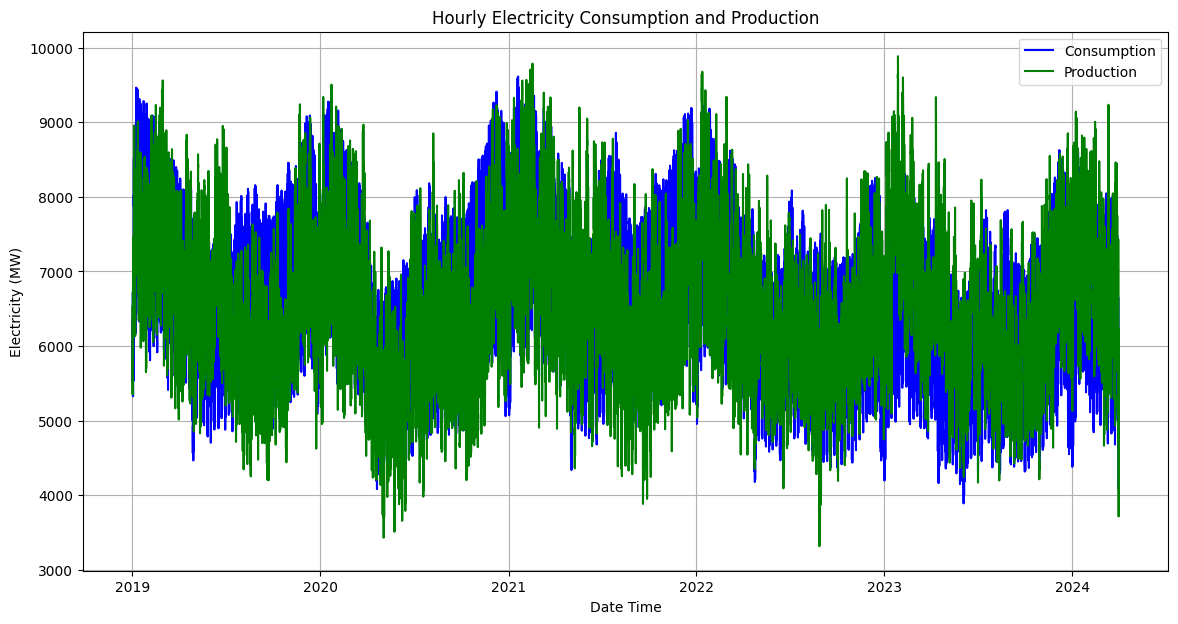

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Consumption'], label='Consumption', color='blue')
plt.plot(df.index, df['Production'], label='Production', color='green')

plt.xlabel('Date Time')
plt.ylabel('Electricity (MW)')
plt.title('Hourly Electricity Consumption and Production')
plt.legend()
plt.grid(True)
plt.show()

- Proportion of Total Electricity Production

*Visualizing the proportion of total electricity production of different energy sources using a pie chart.*

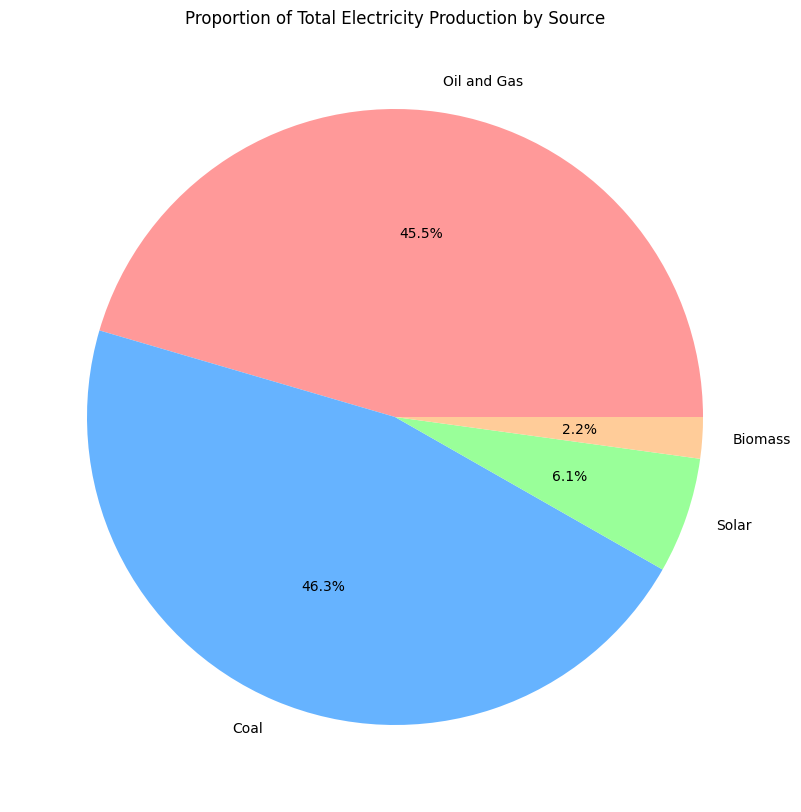

In [8]:
total_production_by_source = df[energy_sources].sum()

plt.figure(figsize=(10, 10))
total_production_by_source.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f'])

plt.ylabel('')
plt.title('Proportion of Total Electricity Production by Source')
plt.show()

- Correlation Matrix of Electricity Production and Consumption Dataset

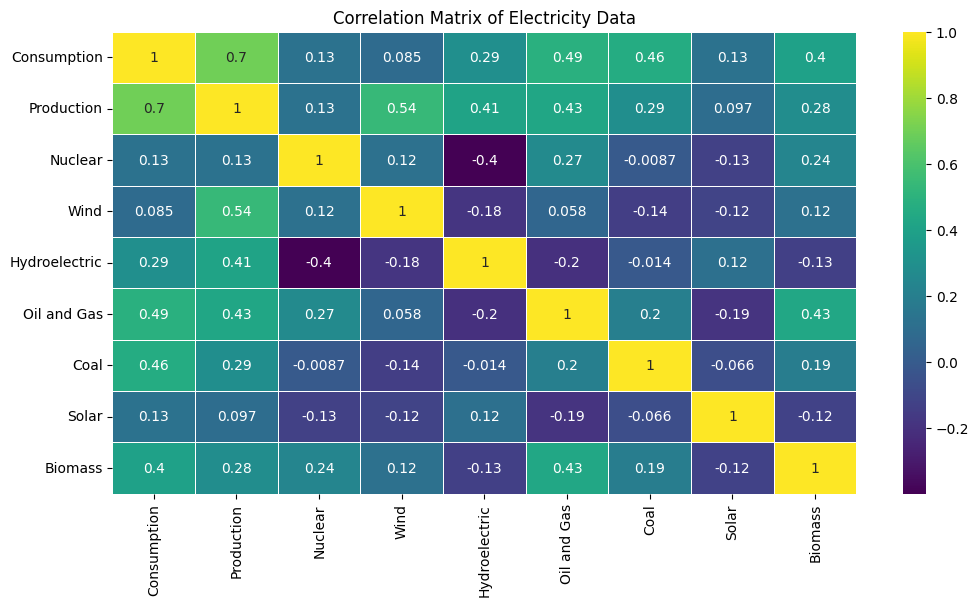

In [18]:
plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

#### 3) Preprocessing

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46011 entries, 2019-01-01 00:00:00 to 2024-03-31 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Consumption    46011 non-null  int64
 1   Production     46011 non-null  int64
 2   Nuclear        46011 non-null  int64
 3   Wind           46011 non-null  int64
 4   Hydroelectric  46011 non-null  int64
 5   Oil and Gas    46011 non-null  int64
 6   Coal           46011 non-null  int64
 7   Solar          46011 non-null  int64
 8   Biomass        46011 non-null  int64
dtypes: int64(9)
memory usage: 3.5 MB


In [17]:
df.describe()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
count,46011.000000,46011.000000,46011.000000,46011.000000,46011.000000,46011.000000,46011.000000,46011.000000,46011.000000
mean,6587.616440,6518.645628,1291.177501,792.310882,1857.052444,1171.890418,1193.157332,156.688031,55.851862
std,1043.654923,986.805018,236.549637,675.812712,692.592157,434.748917,320.449368,229.502650,14.235554
min,3889.000000,3315.000000,562.000000,-26.000000,175.000000,198.000000,279.000000,0.000000,17.000000
25%,5773.000000,5814.000000,1347.000000,236.000000,1347.000000,858.000000,962.000000,0.000000,45.000000
50%,6552.000000,6462.000000,1383.000000,592.000000,1747.000000,1211.000000,1172.000000,2.000000,57.000000
75%,7321.000000,7176.000000,1405.000000,1205.000000,2265.000000,1511.000000,1406.000000,280.000000,67.000000
max,9615.000000,9886.000000,1457.000000,2811.000000,4434.000000,2141.000000,2537.000000,1137.000000,89.000000


- Checking for null data

In [11]:
df.isnull().sum()

DateTime         0
Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64

- Normalize the data

In [4]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'])
scaled_df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,0.430143,0.488814,0.930726,0.037011,0.283635,0.873906,0.648804,0.0,0.180556
1,0.388928,0.363111,0.928492,0.043003,0.220005,0.633556,0.603189,0.0,0.180556
2,0.346490,0.359306,0.928492,0.059217,0.200751,0.652084,0.592117,0.0,0.180556
3,0.313133,0.348197,0.932961,0.076489,0.187133,0.646938,0.566430,0.0,0.180556
4,0.291303,0.325521,0.928492,0.065210,0.184316,0.646423,0.522143,0.0,0.180556


#### 4) Models

 - Check for Stationarity
     - Augmented Dickey-Fuller

In [21]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [22]:
for name, column in scaled_df.items():
    Augmented_Dickey_Fuller_Test_func(column,name)
    print('\n')

Results of Dickey-Fuller Test for column: Consumption
Test Statistic                -1.392647e+01
p-value                        5.182139e-26
No Lags Used                   5.600000e+01
Number of Observations Used    4.595400e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Production
Test Statistic                -1.421803e+01
p-value                        1.676534e-26
No Lags Used                   5.600000e+01
Number of Observations Used    4.595400e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Nuclear
Test Statistic                -7.475816e+00
p-value                

*Since Data is staionary. There is no need for differencing.*



> **Multivariate Timeseries**



- Create sequences

In [5]:
# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

- Train/Test Split

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

- RNN Model

In [26]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Simple RNN Model Training
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
920/920 [==============================] - 20s 19ms/step - loss: 0.0038 - val_loss: 9.9472e-04
Epoch 2/20
920/920 [==============================] - 17s 19ms/step - loss: 0.0011 - val_loss: 6.0995e-04
Epoch 3/20
920/920 [==============================] - 14s 15ms/step - loss: 8.5109e-04 - val_loss: 8.5089e-04
Epoch 4/20
920/920 [==============================] - 14s 15ms/step - loss: 7.9774e-04 - val_loss: 7.6920e-04
Epoch 5/20
920/920 [==============================] - 14s 15ms/step - loss: 7.0775e-04 - val_loss: 6.4659e-04
Epoch 6/20
920/920 [==============================] - 14s 15ms/step - loss: 7.2820e-04 - val_loss: 5.8158e-04
Epoch 7/20
920/920 [==============================] - 14s 15ms/step - loss: 6.6941e-04 - val_loss: 9.7055e-04
Epoch 8/20
920/920 [==============================] - 14s 15ms/step - loss: 6.2777e-04 - val_loss: 5.5741e-04
Epoch 9/20
920/920 [==============================] - 14s 15ms/step - loss: 6.0332e-04 - val_loss: 0.0014
Epoch 10/20
920/920 [=

- RNN Model Evaluation

In [27]:
rnn_predictions = rnn_model.predict(X_test)

# Calculate evaluation metrics for Simple RNN
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

print(f'Simple RNN - R² Score: {rnn_r2}')
print(f'Simple RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'Simple RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'Simple RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')

288/288 [==============================] - 3s 8ms/step
Simple RNN - R² Score: 0.9810267304851632
Simple RNN - Mean Absolute Error (MAE): 0.017343870215225085
Simple RNN - Mean Squared Error (MSE): 0.0005068384119131786
Simple RNN - Root Mean Squared Error (RMSE): 0.022513072023008736


- Actual Vs Predicted Consumption

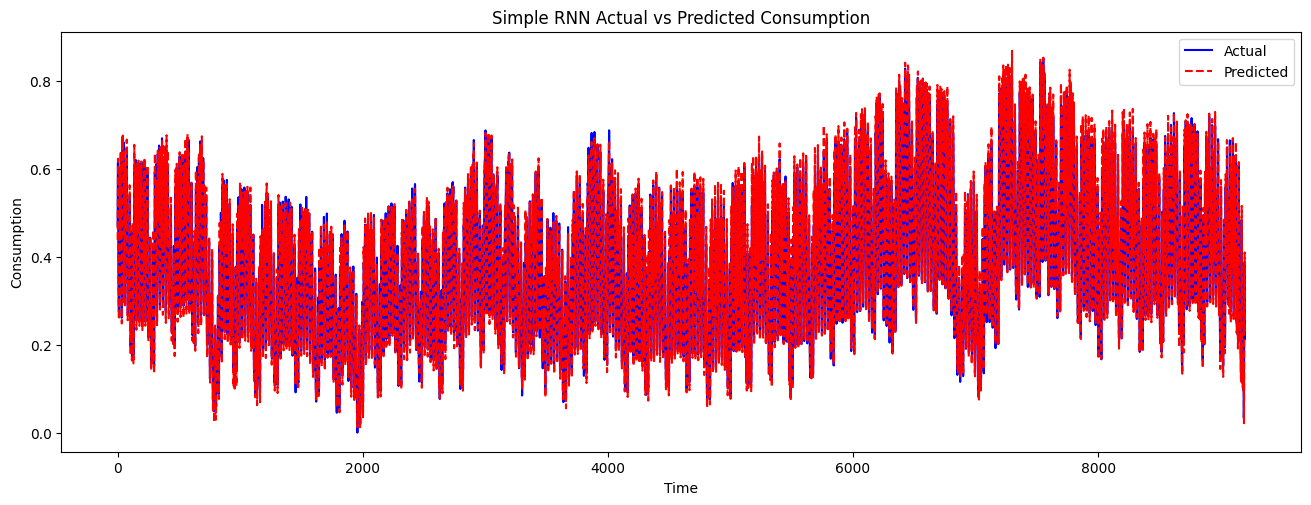

In [28]:
plt.figure(figsize=(16, 12))
# Simple RNN
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(rnn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('Simple RNN Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

- LSTM Model

In [29]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# LSTM Model Training
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
920/920 [==============================] - 32s 29ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 2/20
920/920 [==============================] - 30s 33ms/step - loss: 0.0015 - val_loss: 9.8843e-04
Epoch 3/20
920/920 [==============================] - 30s 33ms/step - loss: 8.3162e-04 - val_loss: 7.0568e-04
Epoch 4/20
920/920 [==============================] - 30s 33ms/step - loss: 6.7109e-04 - val_loss: 6.9591e-04
Epoch 5/20
920/920 [==============================] - 36s 39ms/step - loss: 6.1760e-04 - val_loss: 4.9707e-04
Epoch 6/20
920/920 [==============================] - 41s 45ms/step - loss: 5.6014e-04 - val_loss: 4.6338e-04
Epoch 7/20
920/920 [==============================] - 26s 28ms/step - loss: 5.5925e-04 - val_loss: 4.8358e-04
Epoch 8/20
920/920 [==============================] - 28s 31ms/step - loss: 5.3002e-04 - val_loss: 4.0238e-04
Epoch 9/20
920/920 [==============================] - 27s 30ms/step - loss: 4.9978e-04 - val_loss: 5.2084e-04
Epoch 10/20
920/920 [=

- LSTM Model Evaluation

In [30]:
lstm_predictions = lstm_model.predict(X_test)

# Calculate evaluation metrics for LSTM
lstm_r2 = r2_score(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

print(f'LSTM - R² Score: {lstm_r2}')
print(f'LSTM - Mean Absolute Error (MAE): {lstm_mae}')
print(f'LSTM - Mean Squared Error (MSE): {lstm_mse}')
print(f'LSTM - Root Mean Squared Error (RMSE): {lstm_rmse}')

288/288 [==============================] - 3s 9ms/step
LSTM - R² Score: 0.9850183719600495
LSTM - Mean Absolute Error (MAE): 0.015459071975456979
LSTM - Mean Squared Error (MSE): 0.00040020854379919316
LSTM - Root Mean Squared Error (RMSE): 0.020005212915617597


- Actual Vs Predicted Consumption

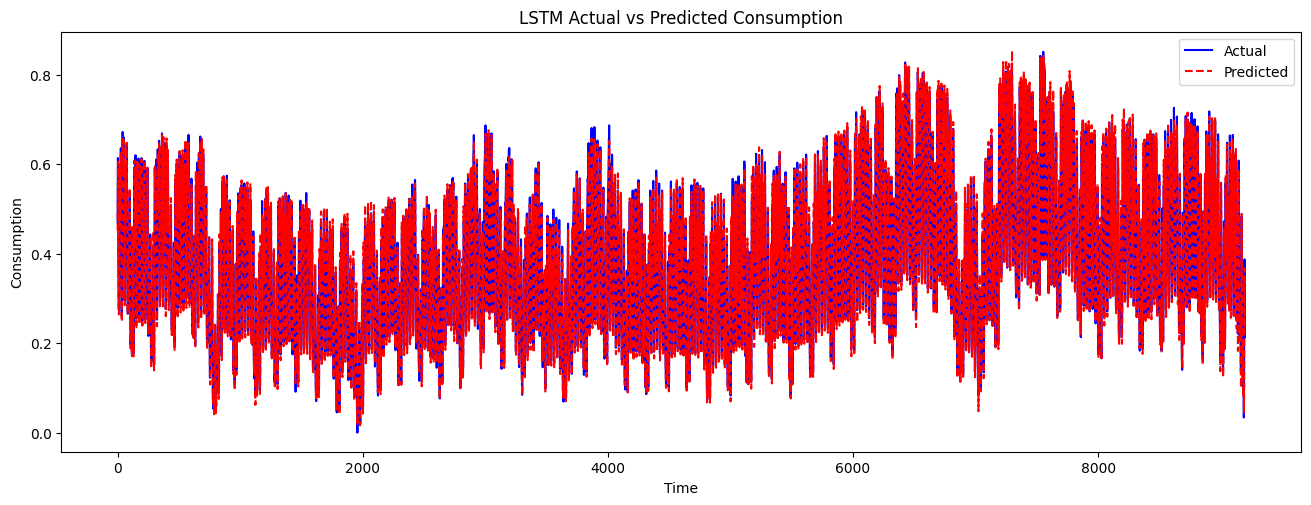

In [31]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(lstm_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('LSTM Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

- TCN Model

In [7]:
tcn_model = Sequential([
    TCN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    TCN(50),
    Dense(1)
])

# Compile the Model
tcn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the TCN Model
tcn_history = tcn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
920/920 [==============================] - 87s 86ms/step - loss: 2.0068 - val_loss: 0.0319
Epoch 2/20
920/920 [==============================] - 76s 82ms/step - loss: 0.0225 - val_loss: 0.0282
Epoch 3/20
920/920 [==============================] - 74s 80ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 4/20
920/920 [==============================] - 73s 79ms/step - loss: 0.0119 - val_loss: 0.0108
Epoch 5/20
920/920 [==============================] - 71s 77ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 6/20
920/920 [==============================] - 73s 79ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 7/20
920/920 [==============================] - 73s 79ms/step - loss: 0.0062 - val_loss: 0.0053
Epoch 8/20
920/920 [==============================] - 72s 78ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 9/20
920/920 [==============================] - 72s 78ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 10/20
920/920 [==============================] - 73s 79ms/step - loss: 0.002

- TCN Model Evaluation

In [8]:
# Make predictions with the TCN model
tcn_predictions = tcn_model.predict(X_test)

# Calculate evaluation metrics for TCN
tcn_r2 = r2_score(y_test, tcn_predictions)
tcn_mae = mean_absolute_error(y_test, tcn_predictions)
tcn_mse = mean_squared_error(y_test, tcn_predictions)
tcn_rmse = np.sqrt(tcn_mse)

print(f'TCN - R² Score: {tcn_r2}')
print(f'TCN - Mean Absolute Error (MAE): {tcn_mae}')
print(f'TCN - Mean Squared Error (MSE): {tcn_mse}')
print(f'TCN - Root Mean Squared Error (RMSE): {tcn_rmse}')

288/288 [==============================] - 7s 22ms/step
TCN - R² Score: 0.9743955131766814
TCN - Mean Absolute Error (MAE): 0.020531679794817764
TCN - Mean Squared Error (MSE): 0.0006839800293373091
TCN - Root Mean Squared Error (RMSE): 0.02615301185977074


- Actual Vs Predicted Consumption

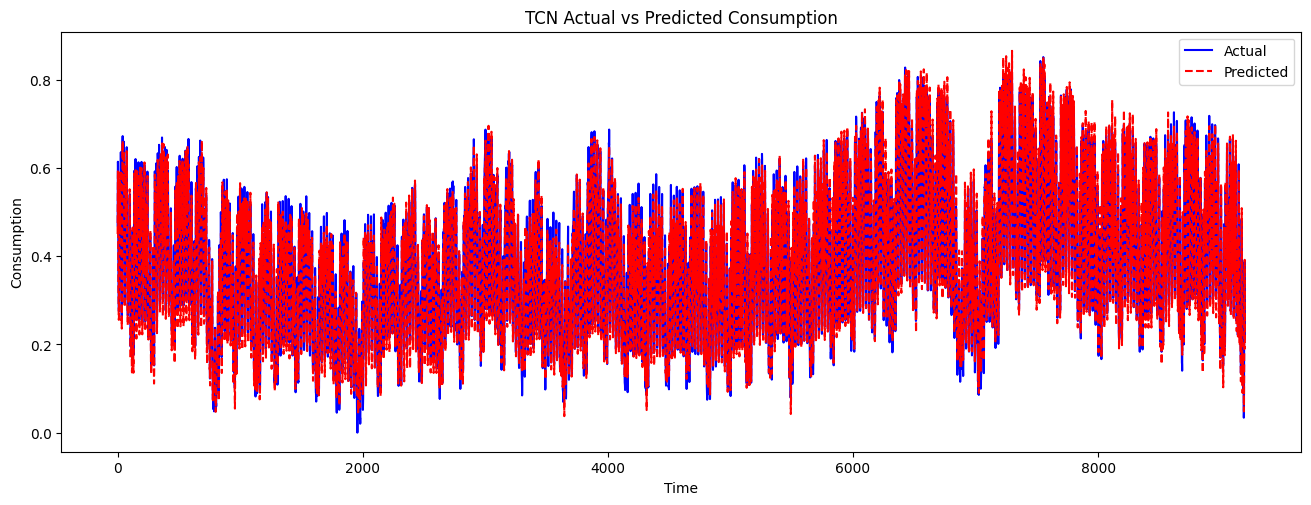

In [10]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.plot(tcn_predictions, label='Predicted', color='red', linestyle='dashed')
plt.title('TCN Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

#### 5) Comparison Table

In [13]:
rnn_metrics = {
    "Model": "Simple RNN",
    "R² Score": rnn_r2,
    "MAE": rnn_mae,
    "MSE": rnn_mse,
    "RMSE": rnn_rmse
}

lstm_metrics = {
    "Model": "LSTM",
    "R² Score": lstm_r2,
    "MAE": lstm_mae,
    "MSE": lstm_mse,
    "RMSE": lstm_rmse
}

tcn_metrics = {
    "Model": "TCN",
    "R² Score": tcn_r2,
    "MAE": tcn_mae,
    "MSE": tcn_mse,
    "RMSE": tcn_rmse
}

comparison_df = pd.DataFrame([rnn_metrics, lstm_metrics, tcn_metrics])
comparison_df.head()


,Model,R² Score,MAE,MSE,RMSE
0,Simple RNN,0.981027,0.017344,0.000507,0.022513
1,LSTM,0.985018,0.015459,0.000400,0.020005
2,TCN,0.974396,0.020532,0.000684,0.026153


In [14]:
# Function to highlight the best result per column
def highlight_best(s):
    is_best = s == s.min() if s.name in ["MAE", "MSE", "RMSE"] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

# Apply the highlighting function
comparison_df.style.apply(highlight_best, subset=["R² Score", "MAE", "MSE", "RMSE"])

,Model,R² Score,MAE,MSE,RMSE
0,Simple RNN,0.981027,0.017344,0.000507,0.022513
1,LSTM,0.985018,0.015459,0.000400,0.020005
2,TCN,0.974396,0.020532,0.000684,0.026153
